In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from sklearn import decomposition
from sklearn.cluster import DBSCAN
from behavior import get_extent, density_map, get_idxs_behav_state
from spatial import gaussian_kernel_2D, get_field_patches
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from population import unit_response_matrix, activity_at_phase

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:]

# showcase
selected = [
    '009266_hippoSIT_2023-05-04_19-47-15',
    '009266_hippoSIT_2023-04-17_17-04-17',
    '009266_hippoSIT_2023-05-23_09-18-05'
]
selected = [
    '009265_hippoSIT_2023-03-09_20-03-08',
    '009265_hippoSIT_2023-03-05_11-52-17'
]
selected

['009265_hippoSIT_2023-03-09_20-03-08', '009265_hippoSIT_2023-03-05_11-52-17']

## Single session

In [23]:
session = selected[0]
session = '009266_hippoSIT_2023-05-04_19-47-15'
session

'009266_hippoSIT_2023-05-04_19-47-15'

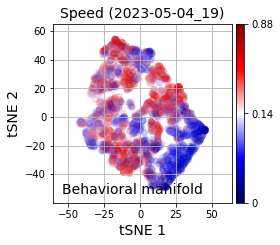

In [53]:
ft = 'tSNE'
fp = 70
animal = session.split('_')[0]
meta_file        = os.path.join(source, animal, session, 'meta.h5')
moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
desc_file  = os.path.join(source, animal, session, 'descendants.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
with h5py.File(moseq_class_file, 'r') as f:
    idxs_srm_tl = np.array(f['idxs_srm_tl'])
    fit = np.array(f[ft][str(fp)])
with h5py.File(desc_file, 'r') as f:
    speed = np.array(f['speed'])

extent = get_extent(fit, margin=10)
b_size = extent[1] - extent[0]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# just manifold
#ax.scatter(fit[:, 0], fit[:, 1], alpha=0.05, color='black')
# speed colored
ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, cmap='seismic', c=np.log(speed[idxs_srm_tl]))
ax.set_title('Speed (%s)' % session[-19:-6], fontsize=14)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_xlabel('tSNE 1', fontsize=14)
ax.set_ylabel('tSNE 2', fontsize=14)
ax.text(extent[0] + 0.05*b_size, extent[2] + 0.05*b_size, 'Behavioral manifold', fontsize=14)
ax.grid()
ax.set_aspect('equal')

# colorbar
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.seismic, orientation='vertical')
cb1.set_ticks([0, 0.5, 1])
cb1.set_ticklabels([0, round(speed.mean(), 2), round(speed.max(), 2)])
plt.gcf().add_axes(ax_cb)

fig.tight_layout()

In [56]:
fig.savefig(os.path.join(report, 'showroom', 'bMAP_speed_%s_single.png' % animal), dpi=500)

## Density plots

https://matplotlib.org/2.0.2/examples/pylab_examples/contour_demo.html

https://matplotlib.org/stable/users/explain/colors/colormaps.html


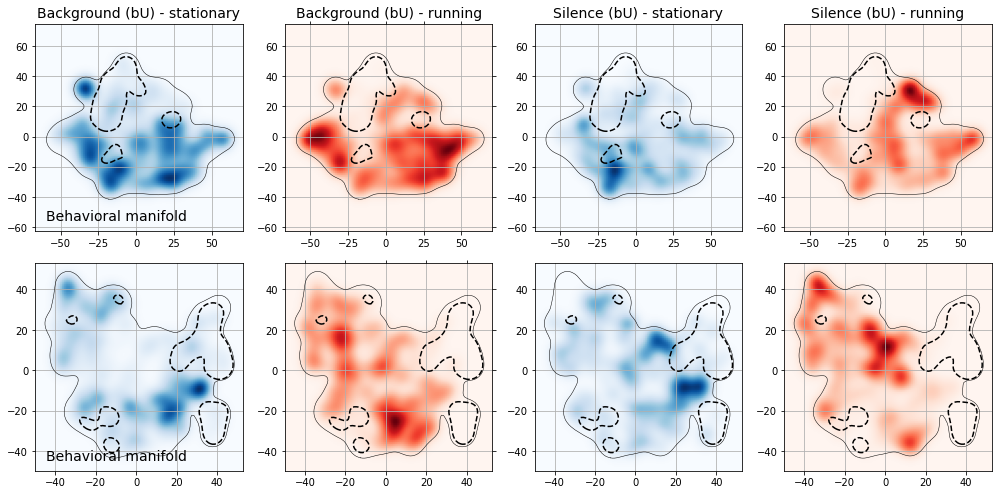

In [22]:
fit_type = 'tSNE'
fit_parm = 70
speed_thresh = 0.04  # m/s
bin_count = 100
#fit_type = 'UMAP'
#fit_parm = 0.5
cmaps  = ['Blues', 'Reds']
rows = len(selected)
cols = 4
size = 3.5
fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

for i, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path           = os.path.join(source, animal, session)
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    state_file = os.path.join(source, animal, session, 'analysis', 'state_idxs.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(moseq_class_file, 'r') as f:
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
        fit = np.array(f[fit_type][str(fit_parm)])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
        hd    = np.array(f['hd'])
    with h5py.File(state_file, 'r') as f:
        idxs_AL_ev = np.array(f['idxs_AL_ev'])  # bAL state
        idxs_neuro_AL_bgr_ev = np.array(f['idxs_neuro_AL_bgr_ev'])
        idxs_neuro_AL_sil_ev = np.array(f['idxs_neuro_AL_sil_ev'])
        idxs_neuro_PH_bgr_ev = np.array(f['idxs_neuro_PH_bgr_ev'])
        idxs_neuro_PH_sil_ev = np.array(f['idxs_neuro_PH_sil_ev'])
        
    idxs_srm_succ = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        tl_l, tl_r = tgt_rec[2], tgt_rec[3]
        idxs_srm_succ += list(np.where((idxs_srm_tl > tl_l) & (idxs_srm_tl < tl_r))[0])
        
    idxs_sta_ev  = np.where(speed[events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
    idxs_run_ev  = np.where(speed[events[:, 2].astype(np.int32)] > speed_thresh)[0]  # define speed filter here
    idxs_srm_sta = np.unique(np.round(idxs_sta_ev/2).astype(np.int32))  # TODO: bring behavior to the same sampling!
    idxs_srm_run = np.unique(np.round(idxs_sta_ev/2).astype(np.int32))  # TODO: bring behavior to the same sampling!
    idxs_srm_bgr = np.where(tl[idxs_srm_tl][:, 6] == 1)[0]
    idxs_srm_sil = np.where(tl[idxs_srm_tl][:, 6] == 0)[0]
    
    idxs_AL_srm = np.unique(np.round(idxs_AL_ev/2).astype(np.int32))
    idxs_PH_srm = np.array([x for x in range(len(fit)) if not x in idxs_AL_srm])
    idxs_srm_bgr_bU = np.intersect1d(idxs_srm_bgr, idxs_PH_srm)
    idxs_srm_sil_bU = np.intersect1d(idxs_srm_sil, idxs_PH_srm)
    
    idxs_srm_sta = np.where(speed[idxs_srm_tl] < speed_thresh)[0]
    idxs_srm_run = np.where(speed[idxs_srm_tl] > speed_thresh)[0]
    
    idxs_srm_bgr_bU_sta = np.intersect1d(idxs_srm_bgr_bU, idxs_srm_sta)
    idxs_srm_sil_bU_sta = np.intersect1d(idxs_srm_sil_bU, idxs_srm_sta)
    idxs_srm_bgr_bU_run = np.intersect1d(idxs_srm_bgr_bU, idxs_srm_run)
    idxs_srm_sil_bU_run = np.intersect1d(idxs_srm_sil_bU, idxs_srm_run)

    sigma = 0.3
    margin = 10
    extent = get_extent(fit, margin=margin)
    b_size = extent[1] - extent[0]
    
    # fit contours
    d_map  = density_map(fit, extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.15*d_map.max(), d_map.max(), 2)
    CS_fit = axes[i][1].contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)

    # success (bE) contours
    d_map   = density_map(fit[idxs_srm_succ], extent, sigma=sigma, bin_count=100)
    levels  = np.linspace(0.25*d_map.max(), d_map.max(), 2)
    CS_succ = axes[i][1].contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)
    
    axes[i][1].clear()  # clear axes from original contours
    #ctrs = measure.find_contours(d_map, 0.25)
    
#     ax = axes[i][0]
#     ax.scatter(fit[:, 0], fit[:, 1], alpha=0.02, color='black')
#     ax.scatter(fit[idxs_srm_succ][:, 0], fit[idxs_srm_succ][:, 1], alpha=0.5, color='tab:orange')
#     ax.set_xlim(extent[0], extent[1])
#     ax.set_ylim(extent[2], extent[3])
#     ax.set_ylabel(session[-19:-6], fontsize=14)
#     ax.grid()
    
#     ax = axes[i][0]
#     ax.scatter(fit[idxs_srm_bgr_bU][:, 0], fit[idxs_srm_bgr_bU][:, 1], alpha=0.1, color='tab:blue')
#     #ax.scatter(fit[idxs_srm_bgr_bU][:, 0], fit[idxs_srm_bgr_bU][:, 1], alpha=0.1, cmap='seismic', c=speed_bU)
#     for path in CS_fit.collections[0].get_paths():
#         verts = path.vertices
#         ax.plot(verts[:,0], verts[:,1], ls='--', color='black')
#     for path in CS_succ.collections[0].get_paths():
#         verts = path.vertices
#         ax.plot(verts[:,0], verts[:,1], color='black')
#     ax.set_xlim(extent[0], extent[1])
#     ax.set_ylim(extent[2], extent[3])
#     ax.grid()

#     ax = axes[i][1]
#     ax.scatter(fit[idxs_srm_sil_bU][:, 0], fit[idxs_srm_sil_bU][:, 1], alpha=0.1, color='black')
#     for path in CS_fit.collections[0].get_paths():
#         verts = path.vertices
#         ax.plot(verts[:,0], verts[:,1], ls='--', color='black')
#     for path in CS_succ.collections[0].get_paths():
#         verts = path.vertices
#         ax.plot(verts[:,0], verts[:,1], color='black')
#     ax.set_xlim(extent[0], extent[1])
#     ax.set_ylim(extent[2], extent[3])
#     ax.grid()

    
    for j, idxs in enumerate([idxs_srm_bgr_bU_sta, idxs_srm_bgr_bU_run]):
        ax = axes[i][j]
        sigma = 0.3
        s_map = density_map(fit[idxs], extent, sigma=sigma, bin_count=bin_count)
        ax.imshow(s_map.T, cmap=cmaps[j], origin='lower', extent=extent)
        for path in CS_fit.collections[0].get_paths():
            verts = path.vertices
            ax.plot(verts[:,0], verts[:,1], lw=0.5, color='black')
        for path in CS_succ.collections[0].get_paths():
            verts = path.vertices
            ax.plot(verts[:,0], verts[:,1], ls='--', color='black')
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.grid()
    
    for j, idxs in enumerate([idxs_srm_sil_bU_sta, idxs_srm_sil_bU_run]):
        ax = axes[i][j+2]
        sigma = 0.3
        s_map = density_map(fit[idxs], extent, sigma=sigma, bin_count=bin_count)
        #s_map[s_map < 0.1*s_map.max()] = 0
        ax.imshow(s_map.T, cmap=cmaps[j], origin='lower', extent=extent)
        for path in CS_fit.collections[0].get_paths():
            verts = path.vertices
            ax.plot(verts[:,0], verts[:,1], lw=0.5, color='black')
        for path in CS_succ.collections[0].get_paths():
            verts = path.vertices
            ax.plot(verts[:,0], verts[:,1], ls='--', color='black')
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.grid()
    
    axes[i][0].text(extent[0] + 0.05*b_size, extent[2] + 0.05*b_size, 'Behavioral manifold', fontsize=14)
    if i == 0:
        axes[i][0].set_title('Background (bU) - stationary', fontsize=14)
        axes[i][1].set_title('Background (bU) - running', fontsize=14)
        axes[i][2].set_title('Silence (bU) - stationary', fontsize=14)
        axes[i][3].set_title('Silence (bU) - running', fontsize=14)
        
fig.tight_layout()

In [23]:
fig.savefig(os.path.join(report, 'showroom', 'bMAP_SIL_BGR_sta_run_%s_sample.png' % animal), dpi=500)

In [18]:
CS_fit.collections[0].get_paths()[0].contains_points()

TypeError: contains_points() missing 1 required positional argument: 'points'